In [2]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


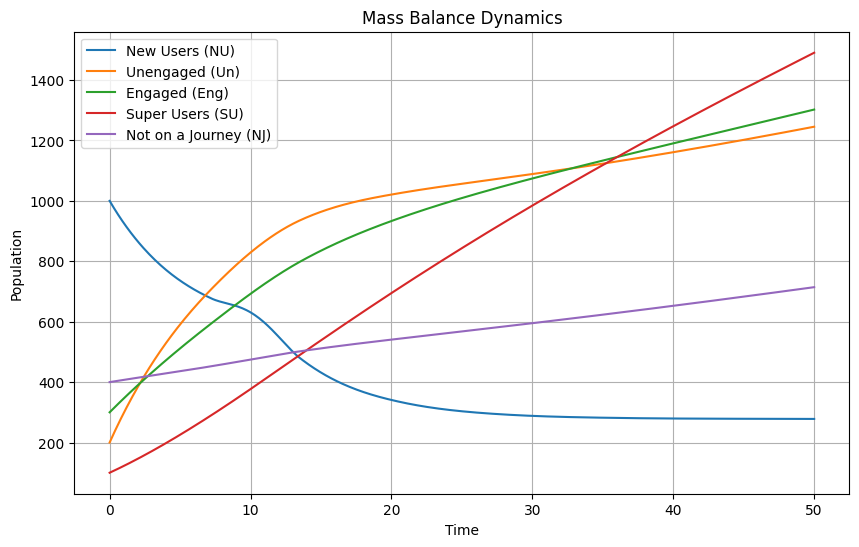

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants for transition rates (example values, adjust as needed)
k = {
    "n_to_un": 0.1, "n_to_eng": 0.05, "n_to_nj": 0.02, "n_to_su": 0.01,
    "un_to_eng": 0.04, "un_to_su": 0.02, "un_to_nj": 0.01,
    "eng_to_un": 0.03, "eng_to_su": 0.02, "eng_to_nj": 0.01,
    "su_to_un": 0.01, "su_to_eng": 0.01, "su_to_nj": 0.005,
    "nj_to_un": 0.02, "nj_to_eng": 0.015, "nj_to_su": 0.01
}

# Define the ODE system
def system(t, y):
    NU, Un, Eng, SU, NJ = y

    # Define the flows for each bucket
    dNU_dt = -NU * (k["n_to_un"] + k["n_to_eng"] + k["n_to_nj"] + k["n_to_su"]) + signups(t)
    dUn_dt = (NU * k["n_to_un"] + Eng * k["eng_to_un"] + SU * k["su_to_un"] + NJ * k["nj_to_un"]
              - Un * (k["un_to_eng"] + k["un_to_su"] + k["un_to_nj"]))
    dEng_dt = (NU * k["n_to_eng"] + Un * k["un_to_eng"] + SU * k["su_to_eng"] + NJ * k["nj_to_eng"]
               - Eng * (k["eng_to_un"] + k["eng_to_su"] + k["eng_to_nj"]))
    dSU_dt = (NU * k["n_to_su"] + Un * k["un_to_su"] + Eng * k["eng_to_su"] + NJ * k["nj_to_su"]
              - SU * (k["su_to_un"] + k["su_to_eng"] + k["su_to_nj"]))
    dNJ_dt = (NU * k["n_to_nj"] + Un * k["un_to_nj"] + Eng * k["eng_to_nj"] + SU * k["su_to_nj"]
              - NJ * (k["nj_to_un"] + k["nj_to_eng"] + k["nj_to_su"]))

    return [dNU_dt, dUn_dt, dEng_dt, dSU_dt, dNJ_dt]

# Define the signups function (can be time-dependent)
def signups(t):
    return 100 if t < 10 else 50  # Example: high signups initially, then reduced

# Initial conditions (adjust as needed)
NU_0 = 1000  # New Users
Un_0 = 200   # Unengaged
Eng_0 = 300  # Engaged
SU_0 = 100   # Super Users
NJ_0 = 400   # Not on a Journey
y0 = [NU_0, Un_0, Eng_0, SU_0, NJ_0]

# Time span for the simulation
t_span = (0, 50)  # Simulate from t=0 to t=50
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points for evaluation

# Solve the ODE system
solution = solve_ivp(system, t_span, y0, t_eval=t_eval, method="RK45")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label="New Users (NU)")
plt.plot(solution.t, solution.y[1], label="Unengaged (Un)")
plt.plot(solution.t, solution.y[2], label="Engaged (Eng)")
plt.plot(solution.t, solution.y[3], label="Super Users (SU)")
plt.plot(solution.t, solution.y[4], label="Not on a Journey (NJ)")

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Mass Balance Dynamics")
plt.legend()
plt.grid()
plt.show()


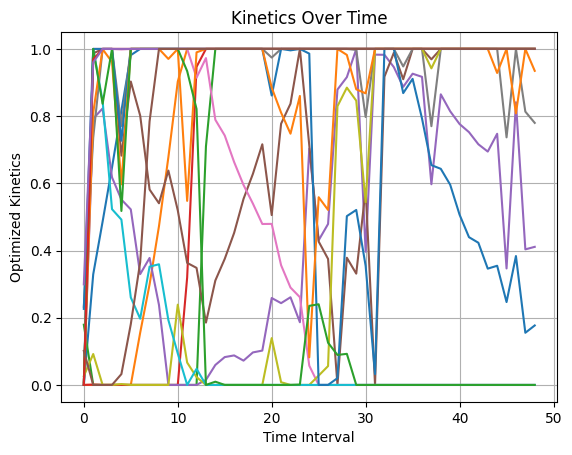

In [8]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Original system constants for simulation
true_k = {
    "n_to_un": 0.1, "n_to_eng": 0.05, "n_to_nj": 0.02, "n_to_su": 0.01,
    "un_to_eng": 0.04, "un_to_su": 0.02, "un_to_nj": 0.01,
    "eng_to_un": 0.03, "eng_to_su": 0.02, "eng_to_nj": 0.01,
    "su_to_un": 0.01, "su_to_eng": 0.01, "su_to_nj": 0.005,
    "nj_to_un": 0.02, "nj_to_eng": 0.015, "nj_to_su": 0.01
}

# Define the ODE system
def system(t, y, k):
    NU, Un, Eng, SU, NJ = y
    dNU_dt = -NU * (k["n_to_un"] + k["n_to_eng"] + k["n_to_nj"] + k["n_to_su"]) + signups(t)
    dUn_dt = (NU * k["n_to_un"] + Eng * k["eng_to_un"] + SU * k["su_to_un"] + NJ * k["nj_to_un"]
              - Un * (k["un_to_eng"] + k["un_to_su"] + k["un_to_nj"]))
    dEng_dt = (NU * k["n_to_eng"] + Un * k["un_to_eng"] + SU * k["su_to_eng"] + NJ * k["nj_to_eng"]
               - Eng * (k["eng_to_un"] + k["eng_to_su"] + k["eng_to_nj"]))
    dSU_dt = (NU * k["n_to_su"] + Un * k["un_to_su"] + Eng * k["eng_to_su"] + NJ * k["nj_to_su"]
              - SU * (k["su_to_un"] + k["su_to_eng"] + k["su_to_nj"]))
    dNJ_dt = (NU * k["n_to_nj"] + Un * k["un_to_nj"] + Eng * k["eng_to_nj"] + SU * k["su_to_nj"]
              - NJ * (k["nj_to_un"] + k["nj_to_eng"] + k["nj_to_su"]))
    return [dNU_dt, dUn_dt, dEng_dt, dSU_dt, dNJ_dt]

# Define the signups function
def signups(t):
    return 100 if t < 10 else 50

# Simulate true data
t_eval = np.linspace(0, 50, 2000)
y0 = [1000, 200, 300, 100, 400]
solution = solve_ivp(system, (0, 50), y0, t_eval=t_eval, args=(true_k,))

# Add noise to simulate measurement error
noise_std = 15
measured_data = solution.y + np.random.normal(0, noise_std, solution.y.shape)

# Define the objective function for optimization
def objective(k_values, t, y_measured, y0):
    # Reconstruct k dictionary
    k = {key: k_values[i] for i, key in enumerate(true_k.keys())}
    # Solve the system with current k values
    sol = solve_ivp(system, (t[0], t[-1]), y0, t_eval=t, args=(k,))
    # Compute error between simulated and measured data
    error = np.sum((sol.y - y_measured) ** 2)
    return error

# Fit kinetics over intervals
intervals = np.arange(0, 50, 1)
optimized_k = []
for i in range(len(intervals) - 1):
    # Get data in the current interval
    mask = (t_eval >= intervals[i]) & (t_eval < intervals[i + 1])
    t_interval = t_eval[mask]
    y_interval = measured_data[:, mask]
    
    # Initial guess for k
    initial_k = [0.01] * len(true_k)
    
    # Optimize
    result = minimize(objective, initial_k, args=(t_interval, y_interval, y0),
                      bounds=[(0, 1)] * len(true_k), method='L-BFGS-B')
    optimized_k.append(result.x)



In [15]:
true_k.keys()

dict_keys(['n_to_un', 'n_to_eng', 'n_to_nj', 'n_to_su', 'un_to_eng', 'un_to_su', 'un_to_nj', 'eng_to_un', 'eng_to_su', 'eng_to_nj', 'su_to_un', 'su_to_eng', 'su_to_nj', 'nj_to_un', 'nj_to_eng', 'nj_to_su'])

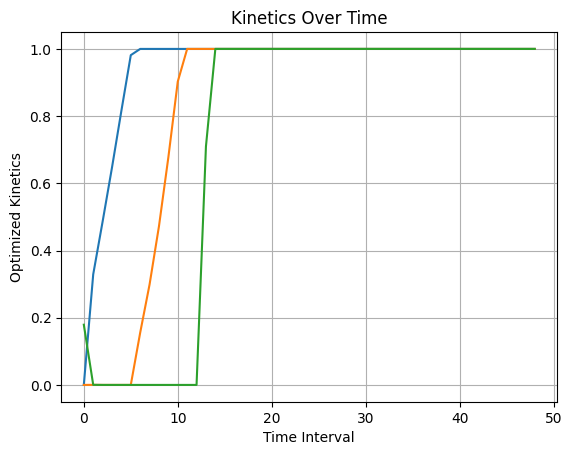

In [17]:
# Plot kinetics over time
optimized_k = np.array(optimized_k)
for i, key in enumerate(['n_to_un','un_to_eng','eng_to_su' ]):
    plt.plot(intervals[:-1], optimized_k[:, i], label=key)

plt.xlabel("Time Interval")
plt.ylabel("Optimized Kinetics")
plt.title("Kinetics Over Time")
# plt.legend()
plt.grid()
plt.show()
